In [2]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd


In [3]:
# initialisation des variables globales
rss.init()

In [14]:
def extract_allowed_chars_from_string(char_list, str):
    res = ''
    for letter in str:
        if letter in char_list:
            res += letter
    return res

def load_image(filepath):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=0)
    return im

In [7]:
df = pd.read_pickle('../pickle/df.pickle')
df['clean_trans'] = df.transcription.apply(lambda x: extract_allowed_chars_from_string(rss.charList, x))
df = df[(df['clean_trans'] != "") & (df['clean_trans'] == df['transcription'])]
X_train, X_test, y_train, y_test = train_test_split(df['word_img_path'].values, df['transcription'].values, test_size=0.1, random_state=42)


In [25]:
liste_img_path = X_train[:64]
liste_label = y_train[:64]

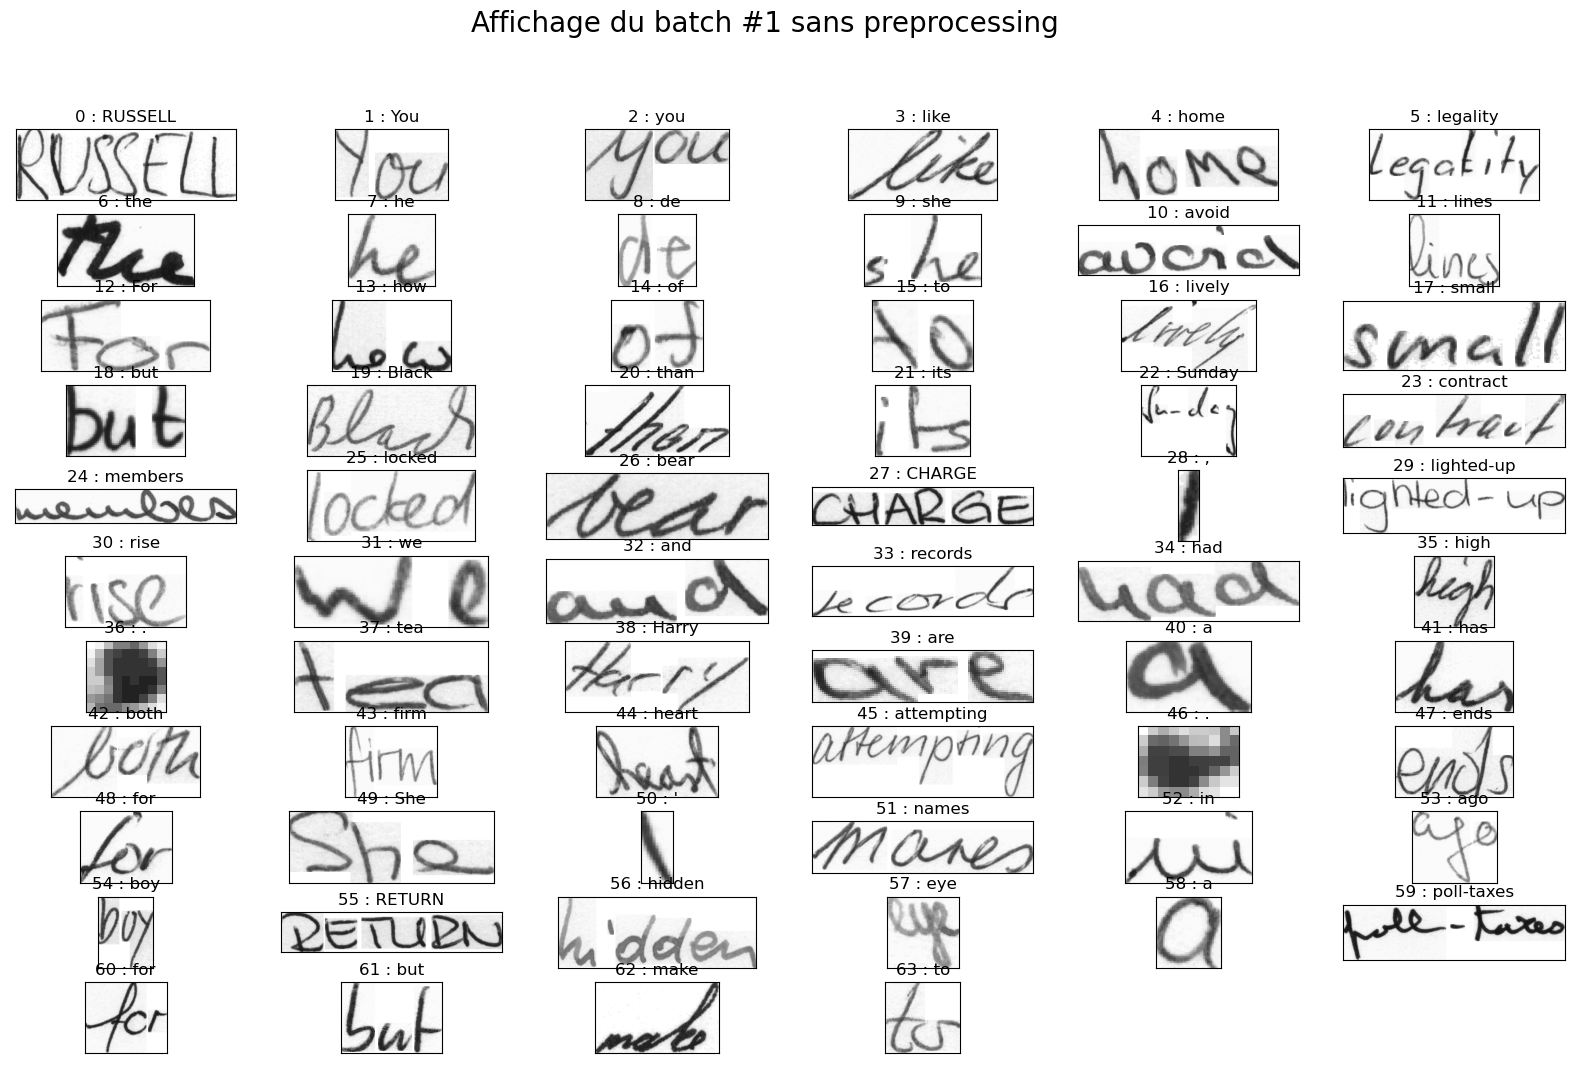

In [32]:
fig = plt.figure(figsize=(20,12))

lin = 11
col = 6

for i in range(len(liste_img_path)):
    # lecture et traitement de chaque image
    img = cv2.imread(liste_img_path[i])
    img = img / 255

    #affichage des subplots
    fig.add_subplot(lin,col,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(str(i)+' : '+str(liste_label[i]))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.suptitle('Affichage du batch #1 sans preprocessing', size = 20);

In [ ]:
def preprocess(filepath, img_size=(32, 128), data_augmentation=False, scale=0.8, is_threshold=False, with_edge_detection=False):
    img = load_image(filepath)/255 # To work with values between 0 and 1
    ### Ajout TJ
    # img = tf.transpose(img, [1, 0, 2])  # np.swapaxes(img, 0, 1)    
    if with_edge_detection:
        padding_value = 0
    else:
        padding_value = 1
    #####
    img_original_size = tf.shape(img)

    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = tf.ones([img_size[0], img_size[1], 1])
        res = tf.expand_dims(img, -1)
        return res

    # increase dataset size by applying random stretches to the images
    if data_augmentation:
        # CODE INITIAL : 
        #stretch = scale*(tf.random.uniform([1], 0, 1)[0] - 0.3) # -0.5 .. +0.5
        #w_stretched = tf.maximum(int(float(img_original_size[0]) * (1 + stretch)), 1) # random width, but at least 1
        #img = tf.image.resize(img, (w_stretched, img_original_size[1])) # stretch horizontally by factor 0.5 .. 1.5
        
        #DEBUG DB
        scale=0.001

        # PROPOSITION DB : le code initial était écrit pour des images 128*32
        stretch = scale*(tf.random.uniform([1], 0, 1)[0] - 0.5) # -0.5 .. +0.5
        w_stretched = tf.maximum(int(float(img_original_size[0]) * (1 + stretch)), 1) # random width, but at least 1
        img = tf.image.resize(img, (w_stretched, img_original_size[1])) # stretch horizontally by factor 0.5 .. 1.5


    # PROPOSITION DB : adaption du code rescale et padding pour des images 32*128
    
    # Rescale
    # create target image and copy sample image into it
    # le nom des variables n'est pas bon? : wt est la hauteur, pas la largeur
    (ht, wt) = img_size
    h, w = float(tf.shape(img)[0]), float(tf.shape(img)[1])
    fx = h / ht
    fy = w / wt
    f = tf.maximum(fx, fy)
    #newSize = (tf.maximum(tf.minimum(wt, int(w / f)), 1), tf.maximum(tf.minimum(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    # PROPOSITION DB : correction de cette ligne
    newSize = (tf.minimum(ht,tf.maximum(1,int(h/f))),tf.minimum(wt,tf.maximum(1,int(w/f))))
    img = tf.image.resize(img, newSize)

    # Add padding
    dx = ht - newSize[0]
    dy = wt - newSize[1]
    if data_augmentation:
        dx1=0
        dy1=0
        if dx != 0:
            dx1 = tf.random.uniform([1], 0, dx, tf.int32)[0]
        if dy != 0:
            dy1 = tf.random.uniform([1], 0, dy, tf.int32)[0]
        img = tf.pad(img[..., 0], [[dx1, dx-dx1], [dy1, dy-dy1]], constant_values=padding_value)
    else:
        img = tf.pad(img[..., 0], [[0, dx], [0, dy]], constant_values=padding_value)


    if is_threshold:
        img = 1-(1-img)*tf.cast(img < 0.8, tf.float32)

    img = tf.expand_dims(img, -1)
    return img

In [96]:
def data_augment(img, img_size=(32,128), data_augmentation=True, scale=0.8):
    
    # CHANGEMENT D'ASPECT RATIO
    img_original_size = tf.shape(img)
    # scale est un scalaire entre 0 et +inf qui amplifie la distribution uniforme entre -50% et +50% de taille horizontale
    scale = .8
    stretch = scale*(tf.random.uniform([1], 0, 1)[0] - 0.5) # -0.5 .. +0.5
    w_stretched = tf.maximum(int(float(img_original_size[1]) * (1 + stretch)), 1) # random width, but at least 1
    img = tf.image.resize(img, (img_original_size[0], w_stretched)) # stretch horizontally by factor 0.5 .. 1.5

    # RESIZE DE L'IMAGE
    (ht, wt) = img_size
    h, w = float(tf.shape(img)[0]), float(tf.shape(img)[1])
    fx = h / ht
    fy = w / wt
    f = tf.maximum(fx, fy)
    newSize = (tf.minimum(ht,tf.maximum(1,int(h/f))),tf.minimum(wt,tf.maximum(1,int(w/f))))
    img = tf.image.resize(img, newSize)
    # A ce stade, l'image a une taille de hauter 32 maxi ou largeur 128 maxi. ensuite il faut faire du padding

    # AJOUT PADDING
    padding_value = 1
    dx = ht - newSize[0]
    dy = wt - newSize[1]
    if data_augmentation:
        dx1=0
        dy1=0
        if dx != 0:
            dx1 = tf.random.uniform([1], 0, dx, tf.int32)[0]
        if dy != 0:
            dy1 = tf.random.uniform([1], 0, dy, tf.int32)[0]
        img = tf.pad(img[..., 0], [[dx1, dx-dx1], [dy1, dy-dy1]], constant_values=padding_value)
    else:
        img = tf.pad(img[..., 0], [[0, dx], [0, dy]], constant_values=padding_value)

    return img, stretch

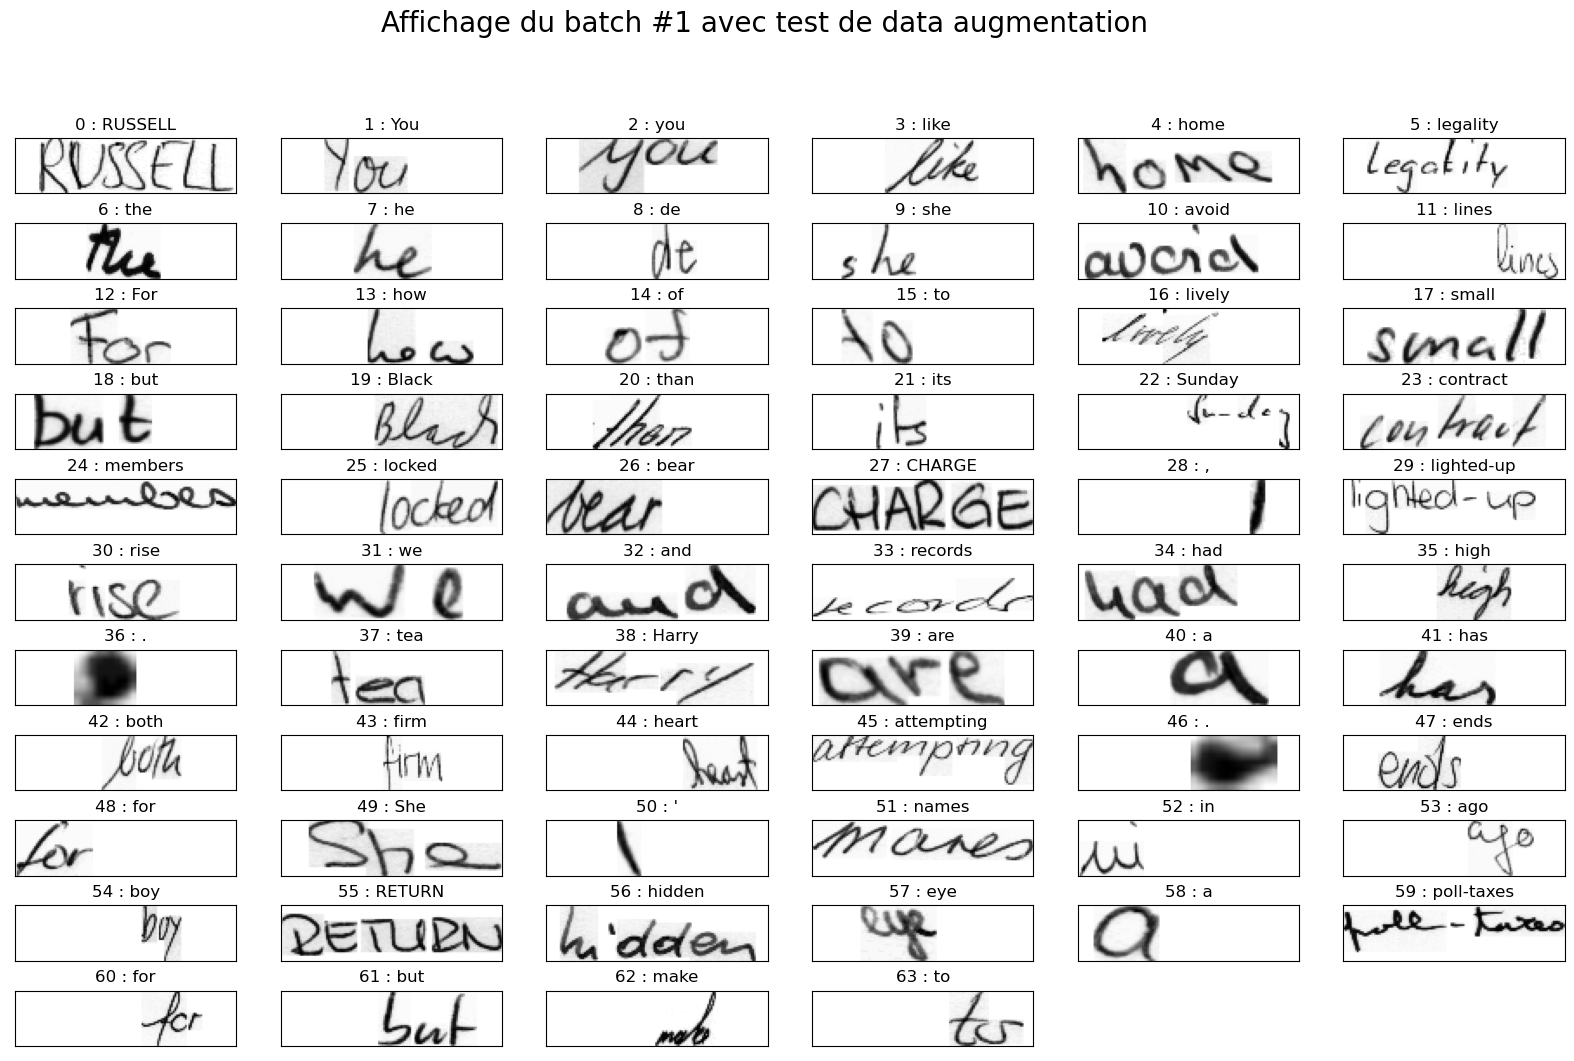

In [97]:
fig = plt.figure(figsize=(20,12))

lin = 11
col = 6


for i in range(len(liste_img_path)):
    # lecture et traitement de chaque image
    img = cv2.imread(liste_img_path[i])
    img = img / 255
    img_da, w_var = data_augment(img, data_augmentation = True)
    
    #debug

    #affichage des subplots
    fig.add_subplot(lin,col,i+1)
    plt.imshow(img_da,cmap='gray')
    #plt.title(str(i)+' : '+str(liste_label[i])+' ; w_delta = %.2f'%w_var)
    plt.title(str(i)+' : '+str(liste_label[i]))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.suptitle('Affichage du batch #1 avec test de data augmentation', size = 20);